In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

%matplotlib inline

In [2]:
dataset = pd.read_csv("./train.csv")[:]

In [3]:
# datasetを読み込む
t_temp = dataset[[0]].values.ravel().astype(np.uint8)
x_dataset = np.array(dataset.iloc[:,1:].values.astype(np.uint8))/256.0
n_dataset = len(t_temp)
t_dataset = np.zeros((n_dataset,10),np.uint8)
t_dataset[np.arange(n_dataset),t_temp]=1 # 1-hot 表現にする


In [4]:
# ランダムシャッフルする
index = np.arange(n_dataset)
np.random.shuffle(index)

x_dataset = x_dataset[index].reshape(len(x_dataset),1,28,28)
t_dataset = t_dataset[index]

# 教師データとテストデータに分割
n_test = n_dataset / 4
n_train = n_dataset - n_test 
x_train , t_train, x_test, t_test = \
    x_dataset[:n_train],t_dataset[:n_train],x_dataset[n_train:],t_dataset[n_train:]

In [5]:
def im2col(input_data,filter_h,filter_w,stride=1,pad=0):
    N,C,H,W = input_data.shape
    out_h = (H+2*pad-filter_h)/stride+1
    out_w = (W+2*pad-filter_w)/stride+1
    
    img = np.pad(input_data,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")
    col = np.zeros((N,C,filter_h,filter_w,out_h,out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:,:,y,x,:,:] = img[:,:,y:y_max:stride,x:x_max:stride]
    
    col = col.transpose(0,4,5,1,2,3).reshape(N*out_h*out_w,-1)
    return col


In [6]:
def col2im(col,input_shape,filter_h,filter_w,stride=1,pad=0):
    N,C,H,W = input_shape
    
    out_h =(H+2*pad-filter_h)/stride + 1
    out_w = (W+2*pad-filter_w)/stride + 1
    col = col.reshape(N,out_h,out_w,C,filter_h,filter_w).transpose(0,3,4,5,1,2)
    
    img = np.zeros((N,C,H+2*pad+stride-1,W+2*pad+stride-1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:,:,y:y_max:stride,x:x_max:stride] += col[:,:,y,x,:,:]
    
    return img[:,:,pad:H+pad,pad:W+pad]
        

In [7]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

(9, 75)


In [8]:
x1 = np.random.rand(10,3,7,7)
col1 = im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

(90, 75)


In [9]:
class Convolution:
    def __init__(self,W,b,stride=1,pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
    
    def forward(self,x):
        FN,C,FH,FW = self.W.shape
        N,C,H,W = x.shape
        
        out_h = int(1+(H+2*self.pad - FH)/self.stride)
        out_w = int(1+(W+2*self.pad - FW)/self.stride)
        
        col = im2col(x,FH,FW,self.stride,self.pad)
        col_W = self.W.reshape(FN,-1).T
        
        out = np.dot(col,col_W)+self.b
        out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self,dout):
        FN,C,FH,FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout,axis=0)
        self.dW = np.dot(self.col.T,dout)
        self.dW = self.dW.transpose(1,0).reshape(FN,C,FH,FW)
        
        dcol = np.dot(dout,self.col_W.T)
        dx = col2im(dcol,self.x.shape,FH,FW,self.stride,self.pad)
        
        return dx

In [10]:
class Pooling:
    def __init__(self,pool_h,pool_w,stride=1,pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
    
    def forward(self,x):
        N,C,H,W = x.shape
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)
        
        col = im2col(x,self.pool_h,self.pool_w,self.stride,self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)
         
        arg_max = np.argmax(col,axis=1)
        out = np.max(col,axis=1)
        out = out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self,dout):
        dout = dout.transpose(0,2,3,1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size,pool_size))
        dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0]*dmax.shape[1] * dmax.shape[2],-1)
        dx = col2im(dcol,self.x.shape,self.pool_h,self.pool_w,self.stride,self.pad)
        
        return dx
    

In [11]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self,x,y):
        out = x+y
        return out

    def backward(self,dout):
        return dout,dout #dx,dy
    
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask]=0
        
        return out
    
    def backward(self,dout):
        dx = dout.copy()
        dx[self.mask] = 0
        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        out = 1.0/(1.0+np.exp(-x))
        self.out = out
        
        return out
    
    def forward(self,dout):
        dx = dout * self.out * ( 1.0- self.out )
        return dx

class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        
        self.dW = None
        self.db = None
    
    def forward(self,x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1)
        self.x = x
        
        out = np.dot(self.x,self.W)+self.b
        
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        
        dx = dx.reshape(*self.original_x_shape)
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        
        return self.loss # スカラー
    
    def backward(self,dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        
        return dx

In [12]:
class SimpleConvNet:
    def __init__(self,input_dim=(1,28,28),
                conv_param={"filter_num":30,
                            "filter_size":5,
                            "pad":0,
                            "stride":1},
                hidden_size=100,output_size=10,weight_init_std=0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad)/filter_stride + 1
        pool_output_size = int( filter_num * (conv_output_size/2)*(conv_output_size/2))
        
        self.params={}
        self.params["W1"] = weight_init_std * np.random.randn(filter_num,input_dim[0],
                                                             filter_size,filter_size)
        self.params["b1"] = np.zeros(filter_num)
        self.params["W2"] = weight_init_std * np.random.randn(pool_output_size,hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params["b3"] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"],
                                          self.params["b1"],
                                          conv_param["stride"],
                                          conv_param["pad"])
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2,pool_w=2,stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"],self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W3"],self.params["b3"])
        
        self.lastLayer = SoftmaxWithLoss()
    
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self,x,t):
        y = self.predict(x)
        return self.lastLayer.forward(y,t)
    
    def accuracy(self,x,t,batch_size=100):
        if t.ndim != 1: t = np.argmax(t,axis=1)
            
        acc=0.0
        
        for i in range(int(x.shape[0]/batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y,axis=1)
            acc += np.sum(y==tt)
        return acc / x.shape[0]
        
    def gradient(self,x,t):
        self.loss(x,t)
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db
        
        return grads
    
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        
        return self.loss # スカラー
    
    def backward(self,dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        
        return dx

def cross_entropy_error(y,t,eps=1e-8):
    """ common/functions.py  """
    
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    # one-hot-vectorから正解ラベルのインデックスに
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    # print y
    # print y[np.arange(batch_size),t]
    return -np.sum(np.log(y[np.arange(batch_size),t]+eps))/batch_size

def softmax(x):
    """ common/functions.py  """
    
    
    # mnistとかやる場合は2次元配列(データ数x入力次元)
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x,axis=0)
        exp_x = np.exp(x)
        y = exp_x / np.sum(exp_x,axis=0)
        return y.T
    
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def sigmoid(x):
    """ シグモイド関数 """
    return 1/(1+np.exp(-x))



In [13]:
epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

train_size = x_train.shape[0]
batch_size = 100
iters_num = x_train.shape[0] / batch_size * epochs
learning_rate = 0.01
momentum = 0.9
h = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size,1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch,t_batch)
    
    if h is None:
        h = {}
        for key , val in grad.items():
            h[key] = np.zeros_like(val)
    
    for key in ["W1","b1","W2","b2","W3","b3"]:
        h[key] += grad[key] * grad[key]
        network.params[key] -= learning_rate * grad[key] / np.sqrt(h[key]+1e-3)
    
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    print("%d/%d: train loss: %lf" % (i,iters_num,loss))
    
    if i % iter_per_epoch == iter_per_epoch - 1:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(train_acc,test_acc)
        

0/3150: train loss: 2.301510
1/3150: train loss: 2.301446
2/3150: train loss: 2.300941
3/3150: train loss: 2.300041
4/3150: train loss: 2.301475
5/3150: train loss: 2.301925
6/3150: train loss: 2.298563
7/3150: train loss: 2.297033
8/3150: train loss: 2.299214
9/3150: train loss: 2.297654
10/3150: train loss: 2.299246
11/3150: train loss: 2.297932
12/3150: train loss: 2.301088
13/3150: train loss: 2.298624
14/3150: train loss: 2.298901
15/3150: train loss: 2.299654
16/3150: train loss: 2.299304
17/3150: train loss: 2.299327
18/3150: train loss: 2.295026
19/3150: train loss: 2.296343
20/3150: train loss: 2.294428
21/3150: train loss: 2.295468
22/3150: train loss: 2.300519
23/3150: train loss: 2.290976
24/3150: train loss: 2.290174
25/3150: train loss: 2.295719
26/3150: train loss: 2.288595
27/3150: train loss: 2.290534
28/3150: train loss: 2.292359
29/3150: train loss: 2.289114
30/3150: train loss: 2.287112
31/3150: train loss: 2.277898
32/3150: train loss: 2.281560
33/3150: train loss:

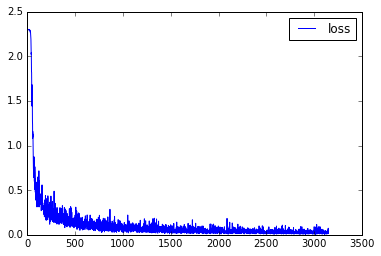

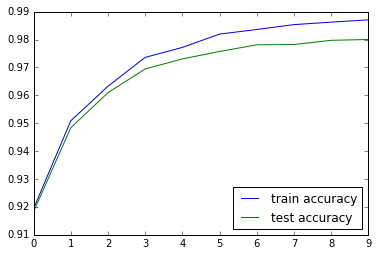

In [18]:
plt.plot(train_loss_list,label="loss")
plt.legend()
plt.show()

plt.plot(train_acc_list,label="train accuracy")
plt.plot(test_acc_list,label="test accuracy")
plt.legend(loc=0)
plt.show()